# Check correlation between features selected for the model

## Plain English summary

We have made our model more simple by selecting 7 features. Informed by those that give the best model performance, when chosen sequentially, and by what clinicians discuss when predicting the outcome based on thrombolysis use.

We are using Shapley values to help to explain how the model has arrived at each prediction. Shapley values require the features to be independent of each other. Any dependencies makes it extremely tricky, and messy, to unpick the allocation to each feature. Here we test the independencies by calculating the correlation between the 6 selected features (after removing stroke team). 

There are only very weak correlations between the six features with no R-squared being greater than 0.15, and all but four being lower than 0.05.

## Data and analysis

Using the full dataset, calculate the correlation between each of these 7 features (the 7 top features sequentially chosen as having the single best improvement in the XGBoost model performance, using the ROC AUC, after removing stroke).

* Prior disability level: Disability level (modified Rankin Scale) before stroke
* Stroke severity: Stroke severity (NIHSS) on arrival
* Age: Age (as middle of 5 year age bands)
* Year: Year of stroke onset
* NIHSS arrival loc: Component of the NIHSS, level of consciousness on arrival
* Scan to thrombolysis time: Time from scan to receiving thrombolysis (minutes)
* Thrombolysis no but improving: Reason given for not receving thrombolysis is the patient is improving

Repeat the correlation analysis for these 6 features (the features have been chosen to be used to train the predictive model, along with stroke team):

* Prior disability level: Disability level (modified Rankin Scale) before stroke
* Stroke severity: Stroke severity (NIHSS) on arrival
* Age: Age (as middle of 5 year age bands)
* Onset to thrombolysis time: Time from onset to receiving thrombolysis (minutes). Set to -100 if did not recieve thrombolysis.
* Any afib diagnosis: Patient has a diagnosis of atrial fibrillation (either on arrival or new)
* Precise onset known: Onset time recorded is  precise time (not a best estimate)

## Aim

* Check correlation (by calculating the correlation) between the 7 top features as selected by sequential feature selection (after removing stroke team), and the 6 features chosen to train the predictive model (after removing stroke team)

## Observations

There are only very weak correlations between the selected features with no R-squared being greater than 0.15, and all but four being lower than 0.05.

## Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import cm
from sklearn.preprocessing import StandardScaler
import json
from dataclasses import dataclass
import time
import datetime
import os
import seaborn as sns

Report the time duration to run notebook

In [2]:
start_time = time.time()

## Set up paths and filenames

Use os.path.join() to create filenames. So define folders without trailing forward slash, and include all characters in file names.

In [3]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''
    image_save_path: str = './saved_images'
    model_save_path: str = './saved_models'
    data_save_path: str = './saved_data'
    data_read_path: str = '../data_processing/output'
    notebook: str = '030_'

paths = Paths()

## Read in JSON file

Contains a dictionary for plain English feature names for the 10 features selected in the model. Use these as the column titles in the DataFrame.

In [4]:
filename = os.path.join(paths.data_save_path, 
                       ('020_feature_name_dict.json'))
with open(filename) as json_file:
    feature_name_dict = json.load(json_file)

## Load data

Combine all of the data (create a dataframe that includes every instance)

In [5]:
filename = os.path.join(paths.data_read_path, '02_reformatted_data_ml.csv')
data = pd.read_csv(filename)
# remove column
if 'id' in data.columns: data.drop(['id'],axis=1,inplace=True)

## Load features to use (drop stroke team if present)

Look at the correlation for two different sets of features:
1. the set from choosing sequentially

In [6]:
# Read in the names of the selected features for the model
filename = os.path.join(paths.data_save_path, 
                       ('020_feature_selection.csv'))
key_features = pd.read_csv(filename)

number_of_features_to_use = 7
key_features = list(key_features['feature'])[:number_of_features_to_use]

# Drop stroke team if present
if 'stroke_team' in key_features:
    key_features.remove('stroke_team')

2. the set from an informed choice from the sequential order

In [7]:
chosen_features = ['prior_disability','stroke_severity','age',
                   'onset_to_thrombolysis_time','any_afib_diagnosis',
                   'precise_onset_known']

Put information in lists (the list of features, and the title to accomapny these feature choices)

In [8]:
subset_features = [key_features, chosen_features]
subset_titles = ["Sequentially selecting features", 
                 "Features in the predictive model"]

### Define functions for the notebook

#### Function to standardise the feature data

In [9]:
def standardise_data(data):
    """
    Standardise the passed data

    Args:
        data [dataframe]: contains columns of data (pre-standardised)
    
    Return:
        data_std [dataframe]: standardise data
    """
    sc = StandardScaler() 
    sc.fit(data)
    data_std = sc.transform(data)
    data_std = pd.DataFrame(data_std, columns=list(data))
    
    return(data_std)

#### Function to calculate correlation between features

In [10]:
def calc_correlation(data_std):
    """
    Standardise the passed data

    Args:
        data_std [dataframe]: contains columns of data (standardised)
    
    Return:
        cov [dataframe]: covariance of each pair-wise features
    """
    # Get covariance
    cov = data_std.cov()

    # Convert from wide to tall
    cov = cov.melt(ignore_index=False)

    # Remove self-correlation
    mask = cov.index != cov['variable']
    cov = cov[mask]

    # Add absolute value
    cov['abs_value'] = np.abs(cov['value'])

    # Add R-squared
    cov['r-squared'] = cov['value'] ** 2

    # Sort by absolute covariance
    cov.sort_values('abs_value', inplace=True, ascending=False)

    # Round to four decimal places
    cov = cov.round(4)

    # Remove duplicate pairs of features
    result = []
    for index, values in cov.iterrows():
        combination = [index, values['variable']]
        combination.sort()
        string = combination[0] + "-" + combination[1]
        result.append(string)
    cov['pair'] = result
    cov.sort_values('pair', inplace=True)
    cov.drop_duplicates(subset=['pair'], inplace=True)
    cov.drop('pair', axis=1, inplace=True)

    # Sort by r-squared
    cov.sort_values('r-squared', ascending=False, inplace=True)

    return(cov)

In [11]:
# Restrict data to chosen features
for features, title in zip(subset_features, subset_titles):

    # Use just the features in the subset
    data_subset = data[features]

    # Standardise data. After scaling data, the reported covariance will be the
    # correlation between data features.
    data_std = standardise_data(data_subset)

    # Rename columns to plain English
    data_std.rename(columns=feature_name_dict, inplace=True)

    # Calculate covariance
    cov = calc_correlation(data_std)

    # Display R-squared (sorted by R-squared)
    print(f'Results for {title} (showing most correlated feature pairs)')
    print()
    print(cov[['variable', 'r-squared']][:10])
    print()


Results for Sequentially selecting features (showing most correlated feature pairs)

                                            variable  r-squared
Stroke severity                    NIHSS arrival loc     0.3233
Age                           Prior disability level     0.1411
Prior disability level               Stroke severity     0.0707
Scan-to-thrombolysis time            Stroke severity     0.0589
Age                                  Stroke severity     0.0356
NIHSS arrival loc             Prior disability level     0.0322
Age                                NIHSS arrival loc     0.0151
Scan-to-thrombolysis time     Prior disability level     0.0142
Age                        Scan-to-thrombolysis time     0.0061
NIHSS arrival loc                               Year     0.0009

Results for Features in the predictive model (showing most correlated feature pairs)

                                              variable  r-squared
Prior disability level                             Age    

Show the correlation (r2 value) as a heatmap.

Make both plots share colour range.

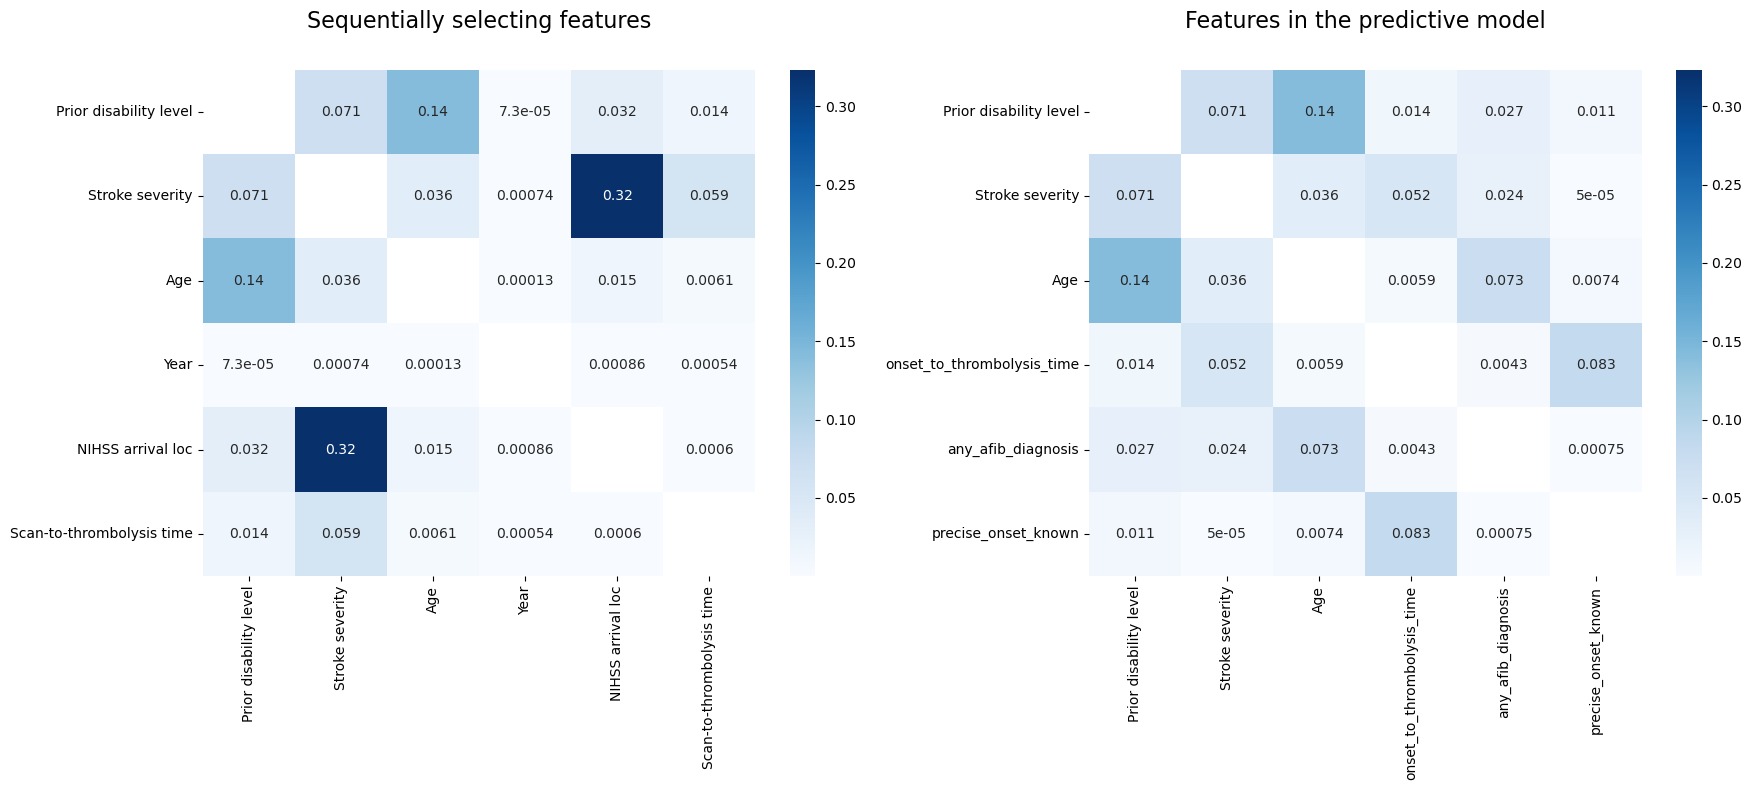

In [31]:
nrows = 1
ncols = 2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18,8))

# Legend height
shrink = 0.5

list_corr_matrix = []

# Want both plots have same color range
vmin = 1
vmax = 0

# Restrict data to chosen features
for features in subset_features:

    # Use just the features in the subset
    data_subset = data[features]

    # Standardise data. After scaling data, the reported covariance will be the
    # correlation between data features.
    data_std = standardise_data(data_subset)

    # Rename columns to plain English
    data_std.rename(columns=feature_name_dict, inplace=True)

    cov_matrix = data_std.cov()
    # Add absolute value
#    matrix_result = np.abs(matrix_result)

    # Add R-squared
    corr_matrix = cov_matrix ** 2

    # Remove diagonal values so not skew the colour map
    for i in range(cov_matrix.shape[0]):
        corr_matrix.iloc[i,i] = np.nan

    # So both plots have same color range
    vmin = min(corr_matrix.min().min(), vmin)
    vmax = max(corr_matrix.max().max(), vmax)

    list_corr_matrix.append(corr_matrix)

# Restrict data to chosen features
for corr_matrix, title, ax in zip(list_corr_matrix, subset_titles, axs):

    #    matrix_result = data_std.corr()
    sns.heatmap(corr_matrix, xticklabels=corr_matrix.columns, 
                yticklabels=corr_matrix.columns, cmap="Blues", annot=True, 
                ax=ax, vmin=vmin, vmax=vmax)
    ax.set_title(title, pad=30, fontsize=16)

filename = os.path.join(paths.image_save_path, 
                        (paths.notebook + '_correlation_heatmaps.jpg'))

plt.savefig(filename, dpi=300)

plt.tight_layout()

## Observations

There are only very weak correlations between the selected features with no R-squared being greater than 0.15, and all but four being lower than 0.05.